In [12]:
# this cell written by Zsolt Balázs & ammended by Asher Bryant
# all other cells below written by Asher Bryant
# --------------------------------------------------------

import plotly.offline as pyo
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
### Set variables ###

first = "all_hematopoietic"
suff = "/summary_across_samples_and_ROIS.csv"

rest = ("all_endo",
        "all_heepic",
        "all_hepatocyte",
        "all_lung",
        "all_mammary",
        "all_melano",
        "all_muscle",
        "all_prostate")
keepcelltype = ("A549_hg38",
                "endothel_FEV_clusters690_739_790_843_890_hg38",
                "epi_tp53_clusters2298_2348_hg38",
                "HEEPIC_PrEC_SAEC_cluster2150_hg38",
                "hematopoietic_specific_liquorice_hg38",
                "hepatocyte_all_hg38",
                "mammary_cluster2239_hg38",
                "melano_FOXA2_cluster2468_hg38",
                "melano_SOX_clusters1863_2205_hg38",
                "prostate_cluster2483_hg38",
                "SAEC_hg38",
                "skeletal_muscle_cluster1518_hg38")
annot = "/mnt/DATA1/Radiooncology/samplemap_with_res.txt"


df = pd.read_csv(first + suff,index_col=False)
for csv in rest:
    next_df = pd.read_csv(csv + suff,index_col=False)
    df = pd.concat([df, next_df])
df["sample"] = df["sample"].str.replace(".sortByCoord", "")
df = df[(df["region-set"].isin(keepcelltype))]

df = df.rename(columns={"Dip area: z-score vs controls in same region set": "area",
                   "Dip depth: z-score vs controls in same region set": "depth"})
df.to_csv("summary.csv",index=False)


# Choosing features for PCA
features = ("depth", "region-set", "sample")
x = df.loc[:, features]# Separating out the target

x_wide=pd.pivot(x, index="sample", columns = 'region-set',values ='depth')
x_wide.reset_index(inplace=True)

# adding annotation

anno_df = pd.read_csv(annot,sep="\t",index_col=False)
x_wide = x_wide.merge(anno_df, how="left", left_on='sample', right_on='sampleNames')
x_wide.to_csv("summary2.csv")

### Perform PCA
x_vals = x_wide.loc[:, keepcelltype].values# Separating out the target
pca = PCA(n_components=2)
components = pca.fit_transform(x_vals)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color_discrete_sequence=px.colors.qualitative.Bold, color=x_wide['group'])
for i, keepcelltype in enumerate(keepcelltype):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=keepcelltype,
    )

fig.show()

/tmp/ipykernel_30885/574704227.py:44: FutureWarning:

The default value of regex will change from True to False in a future version.



In [13]:
keepcelltype = ("A549_hg38",
                "endothel_FEV_clusters690_739_790_843_890_hg38",
                "epi_tp53_clusters2298_2348_hg38",
                "HEEPIC_PrEC_SAEC_cluster2150_hg38",
                "hematopoietic_specific_liquorice_hg38",
                "hepatocyte_all_hg38",
                "mammary_cluster2239_hg38",
                "melano_FOXA2_cluster2468_hg38",
                "melano_SOX_clusters1863_2205_hg38",
                "prostate_cluster2483_hg38",
                "SAEC_hg38",
                "skeletal_muscle_cluster1518_hg38")
heme_z = x_wide['hematopoietic_specific_liquorice_hg38'].tolist()
color_scale = []
for z in heme_z:
    if z > 0:
         scale = z + 15 
    elif z < 0 and z > -5:
        scale = z - 5
    else:
        scale = z 
    color_scale.append(scale)
x_wide['color_scale'] = color_scale
samples = x_wide['sample_x'].tolist()
relevant = ['PV03', 'PV05_R1', 'HN007-BL', 'OMD009-BL', 'PV09-BL', 'HN007-6m-2Eluat']
x_wide['relevant_text'] = [x if x in relevant else "" for x in samples]
x_wide['relevant_text'] = x_wide['relevant_text'].replace({'HN007-6m-2Eluat':'HN007-6m', "PV05_R1": "PV05"})
fig = px.scatter(components, x=0, y=1, text=x_wide['relevant_text'], color=x_wide['color_scale'], 
                 color_continuous_midpoint = 0, color_continuous_scale=px.colors.diverging.RdBu,
                labels={
                     "0": "PC1 (51.7% explained variance)",
                     "1": "PC2 (30.3% explained variance)",
                     "color": "Z-score"
                 })
top_loadings = ["hematopoietic_specific_liquorice_hg38"]
for loading in top_loadings:
    i = keepcelltype.index(loading)
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        #xanchor="left",
        #yanchor="bottom",
        text='hematopoietic',
    )
fig.update_traces(textposition='middle right')
fig.show()
pio.write_image(fig, 'PCA.png', width=2400, height=1600)

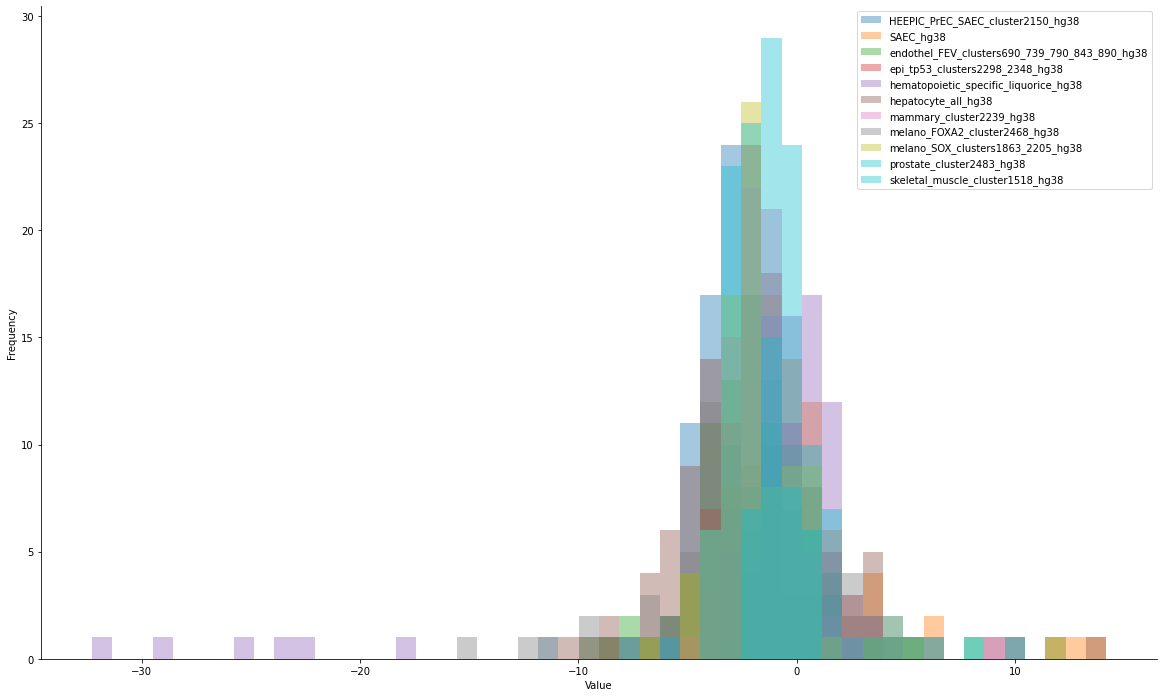

In [14]:
from pca import pca

X = x_wide.set_index('sample_x')
X = X.iloc[:,1:13]
# Make histogram to visualize the spread of the data points.
fig, ax = plt.subplots(figsize=(20, 12))
X.plot.hist(bins=50, cmap='tab10', alpha=0.4, ax=ax)
ax.grid(False); ax.set_xlabel('Value'); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.savefig(f'features_histogram.png',dpi=300)

[pca] >n_components is set to 11
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


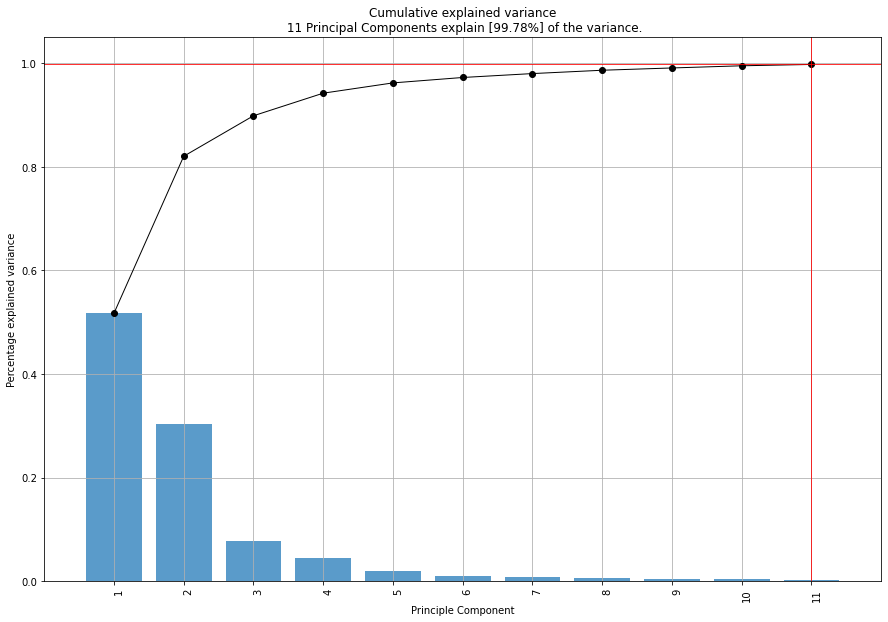

,PC,feature,loading,type
0,PC1,hematopoietic_specific_liquorice_hg38,-0.658580,best
1,PC2,hematopoietic_specific_liquorice_hg38,-0.646699,best
2,PC3,SAEC_hg38,0.607992,best
3,PC4,melano_FOXA2_cluster2468_hg38,0.718348,best
4,PC5,hepatocyte_all_hg38,0.520705,best
5,PC6,SAEC_hg38,0.494946,best
6,PC7,melano_SOX_clusters1863_2205_hg38,0.540205,best
7,PC8,prostate_cluster2483_hg38,-0.656673,best
8,PC9,epi_tp53_clusters2298_2348_hg38,0.620886,best
9,PC10,endothel_FEV_clusters690_739_790_843_890_hg38,0.724847,best


<Figure size 432x288 with 0 Axes>

In [15]:
X = x_wide.iloc[:,1:13]
# Initialize
model = pca(normalize=False, n_components=None)
# Fit transform data
results = model.fit_transform(X)
# Plot the explained variance
model.plot()
plt.savefig(f'scree_plot.png',dpi=300)
# Extract the most informative features
results['topfeat']

[pca] >Plot PC1 vs PC2 with loadings.


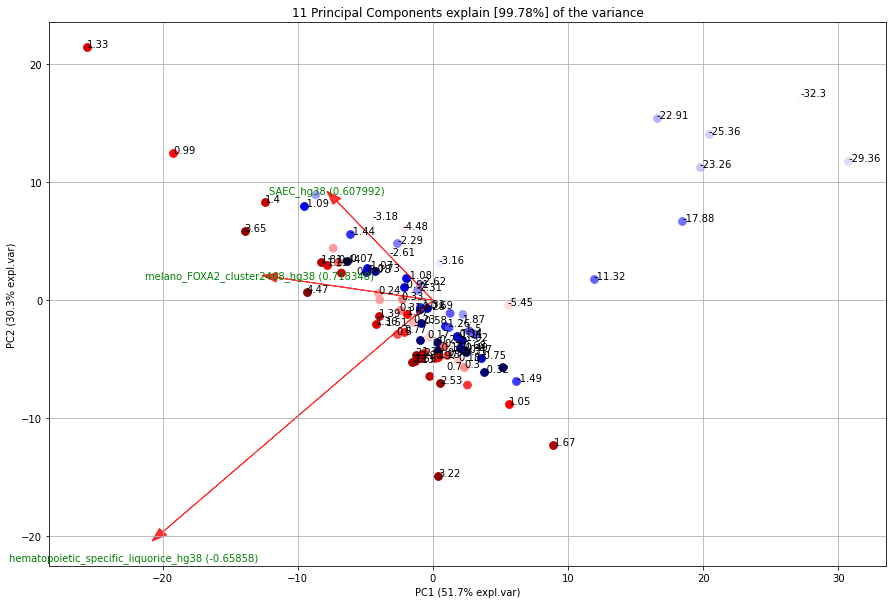

In [16]:
ax = model.biplot(n_feat=3, y=X['hematopoietic_specific_liquorice_hg38'], legend=False, label=True, cmap='seismic')

[pca] >Plot PC1 vs PC2 with loadings.


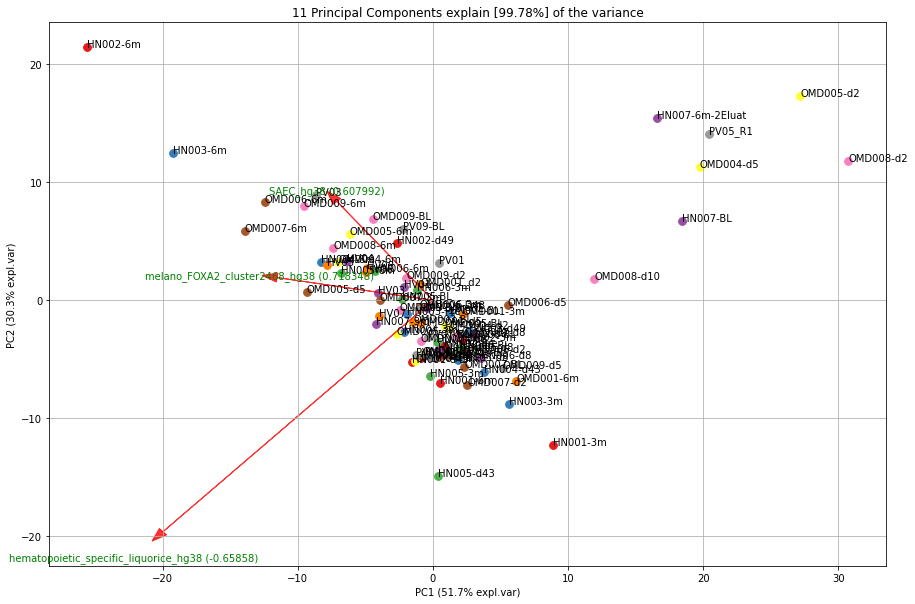

<Figure size 432x288 with 0 Axes>

In [17]:
ax = model.biplot(n_feat=3, y=x_wide['sample_x'], legend=False, label=True)
plt.savefig(f'pca_samples.png',dpi=300)

In [18]:
heme_tmad_corr = x_wide['hematopoietic_specific_liquorice_hg38'].corr(x_wide['tmad_vs_control'])
heme_ss_tmad_corr = x_wide['hematopoietic_specific_liquorice_hg38'].corr(x_wide['tMAD_szsel_90-150_vs_control'])
heme_ichorCNA_corr = x_wide['hematopoietic_specific_liquorice_hg38'].corr(x_wide['tf_ichorcna'])
print(f"hematopoietic-tMAD Pearson's r = {heme_tmad_corr} \nhematopoietic-size-selected tMAD Pearson's r = {heme_ss_tmad_corr} \nhematopoietic-ichorCNA Pearson's r = {heme_ichorCNA_corr}")

hematopoietic-tMAD Pearson's r = -0.08038305779616796 
hematopoietic-size-selected tMAD Pearson's r = -0.07997752548153991 
hematopoietic-ichorCNA Pearson's r = -0.029489719367989338
